# Clustering

Here we implement K-Means and GMM with EM for Clustering and we test it on a random dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_purity(actual, predicted):
    D = np.unique(actual)
    M = np.unique(predicted)
    N = len(actual)
    return 1 / N * sum(max(len(np.intersect1d(np.where(actual == d), np.where(predicted == m))) for d in D) for m in M)

def calculate_rand_index(actual, predicted):
    tp = sum((actual == 1) & (predicted == 1))
    tn = sum((actual == 0) & (predicted == 0))
    fn = sum((actual == 1) & (predicted == 0))
    fp = sum((actual == 0) & (predicted == 1))
    return (tp + tn) / (tp + tn + fn + fp)

In [3]:
from sklearn.datasets.samples_generator import make_classification
X,Y = make_classification(n_samples=700, n_features=10,
                           n_informative=5, n_redundant=0,
                           n_clusters_per_class=2, n_classes=3)

## K-Means

I use the Implementations we have learned in class. Their notebooks are available in the course website.

In [4]:
def find_distance(x, y):

  ##################################Inputs##################################
  # x : (N1 * f) ndarray
  # y : (N2 * f) ndarray
  ##########################################################################

  ##################################Outputs##################################
  #o:  (N1 * N2) ndarray , o[i, j] is the distance of x[i] and y[j] squared
  ##########################################################################

  k = y.shape[0]
  data_size = x.shape[0]

  x_norm = np.repeat(np.expand_dims(np.linalg.norm(x, axis = 1) ** 2, 1), k, axis = 1)
  y_norm = np.repeat(np.expand_dims(np.linalg.norm(y, axis = 1) ** 2, 0), data_size, axis = 0)
  x_y_inner = np.matmul(x, y.T)

  o = x_norm + y_norm - 2 * x_y_inner
  return o

In [5]:
class Kmeans:

    def __init__(self, x, k, max_iters = 1000):
        self.x = x
        self.data_size = x.shape[0]
        self.feature_size = x.shape[1]
        self.k = k
        self.max_iters = max_iters

        self.centers = np.zeros((k, x.shape[1]))

        self.predictions = np.zeros(self.data_size)


    def random_init(self):
      mean = np.mean(self.x, axis = 0)
      std = np.std(self.x, axis = 0)

      centers = np.random.randn(self.k, self.feature_size) * mean + std

      return centers


    def predict(self):

        self.centers = self.random_init()
        for i in range(self.max_iters):
          data_center_dists = find_distance(self.x, self.centers)
          self.predictions = data_center_dists.argmin(axis = 1)

          prev_centers = np.copy(self.centers)

          for j in range(self.k):
            cluster_j = self.x[self.predictions == j] 
            if len(cluster_j) > 0:
              self.centers[j] = cluster_j.mean(axis = 0)

          if (prev_centers == self.centers).all():
            return

In [6]:
def argmax(lst):
  return lst.index(max(lst))
k_means_models = []
purities = []
for i in range(1000):
    model = Kmeans(X, 2)
    model.predict()
    purities.append(calculate_purity(Y, model.predictions))
    k_means_models.append(model)
best = argmax(purities)
best_model = k_means_models[best]
print('Purity of the best model:', purities[best])

Purity of the best model: 0.5171428571428571


In [7]:
print(best_model.centers.shape)
best_model.centers

(2, 10)


array([[ 0.0310138 ,  0.02195296,  0.08348135,  0.37620082,  0.9421883 ,
         0.08568517, -1.22556853, -0.87482535,  0.1222052 ,  0.06429122],
       [-0.14204895, -0.03842697, -0.03317869,  0.90635136, -1.04337101,
        -0.06874548,  0.65357046,  0.09342668, -0.09921494, -0.91046879]])

## GMM and EM

In [8]:
class GaussianMixtureModel:
    def __init__(self, K):
        self.K = K
        self.Pi = None
        self.Mu = None
        self.Sigma = None
                
    def _init_params(self, X, best_model, random_state=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        '''
        n_samples, n_features = np.shape(X)
        rnd = np.random.RandomState(seed=random_state)
        
        self.Pi = np.ones(self.K)/self.K
        # We are aske to set the initial centers as the K-means centers
        self.Mu = best_model.centers
        self.Sigma = np.tile(np.diag(np.var(X, axis=0)), (self.K, 1, 1))

        
    def _calc_nmat(self, X):
        '''
        Method for calculating array corresponding $\mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Nmat : 2D numpy array
            2-D numpy array representing probability density for each sample and each component, 
            where Nmat[n, k] = $\mathcal{N}(x_n | \mu_k)$.
        
        '''
        n_samples, n_features = np.shape(X)
         
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        L = np.linalg.inv(self.Sigma)
        exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", Diff, L), Diff)
        Nmat = np.exp(-0.5*exponent)/np.sqrt(np.linalg.det(self.Sigma))   / (2*np.pi)**(n_features/2)
        return Nmat
        
    def _Estep(self, X):
        '''
        Method for calculating the array corresponding to responsibility.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        n_samples, n_features = np.shape(X)
        Nmat = self._calc_nmat(X)
        tmp = Nmat * self.Pi
        Gam = tmp/np.reshape(np.sum(tmp, axis=1), (n_samples, 1) )
        return Gam
        
    def _Mstep(self, X, Gam):
        '''
        Method for calculating the model parameters based on the responsibility gamma.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        '''
        n_samples, n_features = np.shape(X)
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        Nk = np.sum(Gam, axis=0)
        self.Pi = Nk/n_samples
        self.Mu = Gam.T @ X / np.reshape(Nk, (self.K, 1))
        self.Sigma = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki", Gam, Diff), Diff) / np.reshape(Nk, (self.K, 1, 1))
        
    def calc_prob_density(self, X):
        '''
        Method for calculating the probablity density $\sum_k \pi_k \mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        prob_density : 2D numpy array

        '''
        prob_density = self._calc_nmat(X) @ self.Pi
        return prob_density
        
        
    def calc_log_likelihood(self, X):
        '''
        Method for calculating the log-likelihood for the input X and current model parameters.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Returns
        ----------
        loglikelihood : float
            The log-likelihood of the input data X with respect to current parameter set.
        
        '''
        log_likelihood = np.sum(np.log(self.calc_prob_density(X)))
        return log_likelihood
        
        
    def fit(self, X, max_iter, tol, disp_message, best_model, random_state=None):
        '''
        Method for performing learning. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : int
            Maximum number of iteration
        tol : float, positive
            Precision. If the change of parameter is below this value, the iteration is stopped
        disp_message : Boolean
            Whether or not to show the message about the number of iteration
        '''
        self._init_params(X, best_model, random_state=random_state)
        log_likelihood = - np.float("inf")
        
        for i in range(max_iter):
            Gam = self._Estep(X)
            self._Mstep(X, Gam)
            log_likelihood_old = log_likelihood
            log_likelihood = self.calc_log_likelihood(X)
            
            if  log_likelihood - log_likelihood_old < tol:
                break
        if disp_message:
            print(f"n_iter : {i}")
            print(f"log_likelihood : {log_likelihood}")
            
    def predict_proba(self, X):
        '''
        Method for calculating the array corresponding to responsibility. Just a different name for _Estep
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        Gam = self._Estep(X)
        return Gam
    
    def predict(self, X):
        '''
        Method for make prediction about which cluster input points are assigned to.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        pred : 1D numpy array
            1D numpy array, with dtype=int, representing which class input points are assigned to.
        '''
        pred = np.argmax(self.predict_proba(X), axis=1)
        return pred

In [9]:
gmm = GaussianMixtureModel(K=2)
gmm.fit(X, max_iter=30, tol=1e-1, disp_message=True, best_model=best_model, random_state=0)

n_iter : 22
log_likelihood : -11253.468195446483


In [10]:
print(gmm.Mu.shape)
gmm.Mu

(2, 10)


array([[ 0.02981795,  0.04085672,  0.03907643,  0.56463433,  0.55176887,
         0.06443026, -0.97323811, -0.75807602,  0.08312433, -0.09720981],
       [-0.20973811, -0.10269418,  0.01292404,  0.72495208, -1.02740167,
        -0.08667223,  0.88496795,  0.24057178, -0.10681129, -0.96609688]])

### Evaluation

In [11]:
# For K-means
print('Purity K-Means:', calculate_purity(Y, best_model.predictions))
print('Rand Index K-Means:', calculate_rand_index(Y, best_model.predictions))

Purity K-Means: 0.5171428571428571
Rand Index K-Means: 0.7685774946921444


In [12]:
# For GMM and EM
print('Purity EM:', calculate_purity(Y, gmm.predict(X)))
print('Rand Index EM:', calculate_rand_index(Y,  gmm.predict(X)))

Purity EM: 0.51
Rand Index EM: 0.7579617834394905


Here we Try out different random datasets and plot the results.

In [13]:
def plot_result_k_means(model, X):
    plt.scatter(X[model.predictions == 0, 0], X[model.predictions == 0, 1])
    plt.scatter(X[model.predictions == 1, 0], X[model.predictions == 1, 1])
    plt.scatter(model.centers[:, 0], model.centers[:, 1], color='black')

    plt.legend(['cluster 1', 'cluster 2'])
    plt.show()

In [14]:
def plot_result_gmm(model, X):
    plt.scatter(X[model.predict(X) == 0, 0], X[model.predict(X) == 0, 1])
    plt.scatter(X[model.predict(X) == 1, 0], X[model.predict(X) == 1, 1])
    plt.scatter(model.Mu[:, 0], model.Mu[:, 1], color='black')

    plt.legend(['cluster 1', 'cluster 2'])
    plt.show()

In [15]:
def plot_original(X, Y):
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
    plt.scatter(X[Y == 1, 0], X[Y== 1, 1])

    plt.legend(['cluster 1', 'cluster 2'])
    plt.show()

## Dataset 1

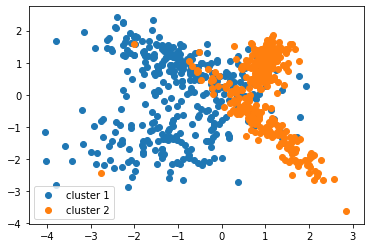

In [16]:
from sklearn.datasets.samples_generator import make_classification
X_new, Y_new = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)
plot_original(X_new, Y_new)

## K-means

In [17]:
k_means_models_new = []
purities_new = []
for i in range(1000):
    model = Kmeans(X_new, 2)
    model.predict()
    purities_new.append(calculate_purity(Y_new, model.predictions))
    k_means_models_new.append(model)
best = argmax(purities_new)
best_model_new = k_means_models_new[best]
print('Purity of the best model:', purities_new[best])
print(best_model_new.centers)

Purity of the best model: 0.8585714285714285
[[-1.43788601 -0.0077688 ]
 [ 0.8774836  -0.01473765]]


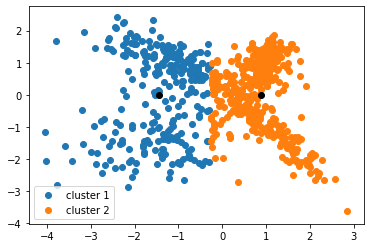

In [18]:
plot_result_k_means(best_model_new, X_new)

## EM

In [19]:
gmm_new = GaussianMixtureModel(K=2)
gmm_new.fit(X_new, max_iter=100, tol=1e-1, disp_message=True, best_model=best_model_new, random_state=0)

n_iter : 19
log_likelihood : -2193.348390367297


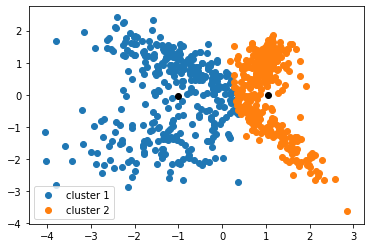

In [20]:
plot_result_gmm(gmm_new, X_new)

In [21]:
# For K-means
print('Purity K-Means:', calculate_purity(Y_new, best_model_new.predictions))
print('Rand Index K-Means:', calculate_rand_index(Y_new, best_model_new.predictions))
# For GMM and EM
print('Purity EM:', calculate_purity(Y_new, gmm_new.predict(X_new)))
print('Rand Index EM:', calculate_rand_index(Y_new,  gmm_new.predict(X_new)))

Purity K-Means: 0.8585714285714285
Rand Index K-Means: 0.8585714285714285
Purity EM: 0.8871428571428571
Rand Index EM: 0.8871428571428571


In this dataset, both models are predicting well.

## Dataset 2

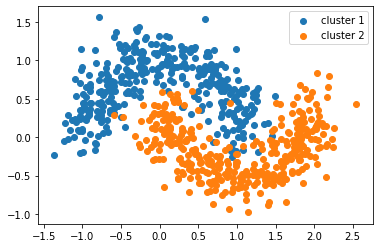

In [22]:
from sklearn.datasets.samples_generator import make_moons
X_moon, Y_moon = make_moons(n_samples=700, noise=0.2)
plot_original(X_moon, Y_moon)

## K-Means

In [23]:
k_means_models_moon = []
purities_moon = []
for i in range(1000):
    model = Kmeans(X_moon, 2)
    model.predict()
    purities_moon.append(calculate_purity(Y_moon, model.predictions))
    k_means_models_moon.append(model)
best = argmax(purities_moon)
best_model_moon = k_means_models_moon[best]
print('Purity of the best model:', purities_moon[best])
print(best_model_moon.centers)

Purity of the best model: 0.7514285714285714
[[ 1.24104438 -0.08008955]
 [-0.20111376  0.57492669]]


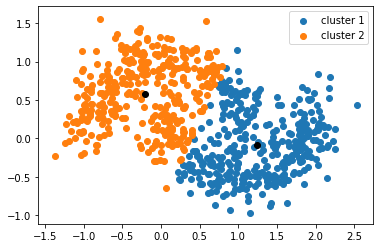

In [24]:
plot_result_k_means(best_model_moon, X_moon)

## EM

In [28]:
gmm_moon = GaussianMixtureModel(K=2)
gmm_moon.fit(X_moon, max_iter=100, tol=1e-1, disp_message=True, best_model=best_model_moon, random_state=0)

n_iter : 6
log_likelihood : -1322.1524738253247


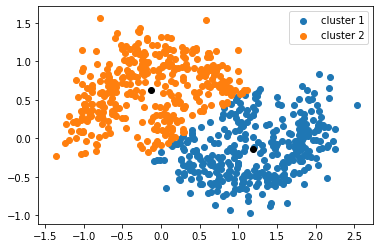

In [29]:
plot_result_gmm(gmm_moon, X_moon)

In [30]:
# For K-means
print('Purity K-Means:', calculate_purity(Y_moon, best_model_moon.predictions))
print('Rand Index K-Means:', calculate_rand_index(Y_moon, best_model_moon.predictions))
# For GMM and EM
print('Purity EM:', calculate_purity(Y_moon, gmm_moon.predict(X_moon)))
print('Rand Index EM:', calculate_rand_index(Y_moon,  gmm_moon.predict(X_moon)))

Purity K-Means: 0.7514285714285714
Rand Index K-Means: 0.24857142857142858
Purity EM: 0.8314285714285714
Rand Index EM: 0.16857142857142857


For the moon data set, GMM performed better due to the reported metrics.

## Dataset 3

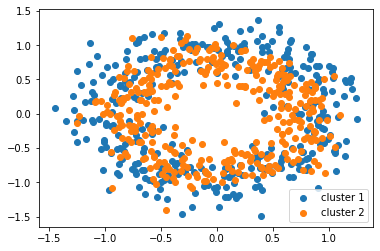

In [31]:
from sklearn.datasets.samples_generator import make_circles
X_circle, Y_circle = make_circles(n_samples=700, noise=0.2)
plot_original(X_circle, Y_circle)

## K-Means

In [32]:
k_means_models_circle = []
purities_circle = []
for i in range(1000):
    model = Kmeans(X_circle, 2)
    model.predict()
    purities_circle.append(calculate_purity(Y_circle, model.predictions))
    k_means_models_circle.append(model)
best = argmax(purities_circle)
best_model_circle = k_means_models_circle[best]
print('Purity of the best model:', purities_circle[best])
print(best_model_circle.centers)

Purity of the best model: 0.5157142857142857
[[ 0.56570971 -0.02910996]
 [-0.58224274  0.02488291]]


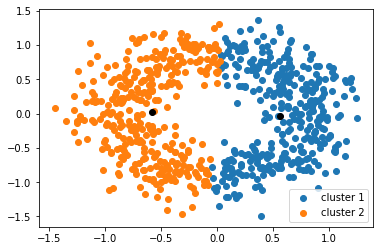

In [33]:
plot_result_k_means(best_model_circle, X_circle)

## EM

In [34]:
gmm_circle = GaussianMixtureModel(K=2)
gmm_circle.fit(X_circle, max_iter=100, tol=1e-1, disp_message=True, best_model=best_model_circle, random_state=0)

n_iter : 8
log_likelihood : -1335.2610405061102


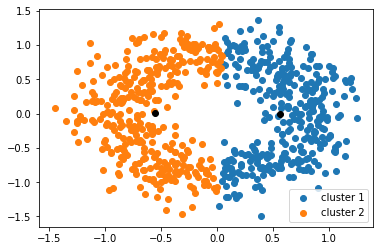

In [35]:
plot_result_gmm(gmm_circle, X_circle)

In [36]:
# For K-means
print('Purity K-Means:', calculate_purity(Y_circle, best_model_circle.predictions))
print('Rand Index K-Means:', calculate_rand_index(Y_circle, best_model_circle.predictions))
# For GMM and EM
print('Purity EM:', calculate_purity(Y_circle, gmm_circle.predict(X_circle)))
print('Rand Index EM:', calculate_rand_index(Y_circle,  gmm_circle.predict(X_circle)))

Purity K-Means: 0.5157142857142857
Rand Index K-Means: 0.5157142857142857
Purity EM: 0.5128571428571429
Rand Index EM: 0.5128571428571429


In the circle data set the both methods perform almost the same and their performance were not good. This is because of the shape of the data that is not seperabale and like a ring.